# Introduction
This python notebook is for Beer reviews analysis

In [54]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from ast import literal_eval

## Data Pre-processing
* Reading csv file
* Converting object datatype to category
* Removing null values

In [5]:
# Path to data
DATA_PATH = os.path.join("data", "BeerDataScienceProject.csv")

In [6]:
# Load dataset in beer_df dataframe
beer_df = pd.read_csv(DATA_PATH)

In [7]:
# Analyzing the datatypes of columns
beer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508590 non-null  float64
 1   beer_beerId         528870 non-null  int64  
 2   beer_brewerId       528870 non-null  int64  
 3   beer_name           528870 non-null  object 
 4   beer_style          528870 non-null  object 
 5   review_appearance   528870 non-null  float64
 6   review_palette      528870 non-null  float64
 7   review_overall      528870 non-null  float64
 8   review_taste        528870 non-null  float64
 9   review_profileName  528755 non-null  object 
 10  review_aroma        528870 non-null  float64
 11  review_text         528751 non-null  object 
 12  review_time         528870 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 52.5+ MB


In [8]:
# Getting count of values in each column
unique_counts = pd.DataFrame.from_records([(col, beer_df[col].nunique()) for col in beer_df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
6,review_palette,9
8,review_taste,9
10,review_aroma,9
5,review_appearance,10
7,review_overall,10
4,beer_style,104
0,beer_ABV,283
2,beer_brewerId,1803
3,beer_name,18339
1,beer_beerId,20200


In [10]:
# Convert object datatype to category using threshold value
columns_to_convert = ['beer_name', 'beer_style', 'review_profileName']

for col in columns_to_convert:
        beer_df[col] = beer_df[col].astype('category')

# Memory reduced to 44.2 MB after converting object datatype to Category
beer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_ABV            508590 non-null  float64 
 1   beer_beerId         528870 non-null  int64   
 2   beer_brewerId       528870 non-null  int64   
 3   beer_name           528870 non-null  category
 4   beer_style          528870 non-null  category
 5   review_appearance   528870 non-null  float64 
 6   review_palette      528870 non-null  float64 
 7   review_overall      528870 non-null  float64 
 8   review_taste        528870 non-null  float64 
 9   review_profileName  528755 non-null  category
 10  review_aroma        528870 non-null  float64 
 11  review_text         528751 non-null  object  
 12  review_time         528870 non-null  int64   
dtypes: category(3), float64(6), int64(3), object(1)
memory usage: 44.2+ MB


In [11]:
# Analyzing null values
beer_df.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [12]:
# Removing na values
beer_df = beer_df.dropna()

## 1.	Rank top 3 Breweries which produce the strongest beers?
Using beer_abv column to fetch top 3 breweries

**Answer**

* **Schorschbr�u Schorschbock 57%**	
* **Schorschbr�u Schorschbock 43%**
* **Schorschbr�u Schorschbock 40%**

<AxesSubplot:xlabel='beer_name'>

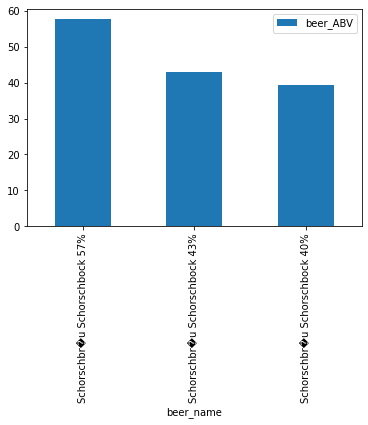

In [18]:
top_3_abv_df = beer_df.drop_duplicates('beer_name').nlargest(3, ['beer_ABV'])
top_3_abv_df.plot(x ='beer_name', y='beer_ABV', kind='bar')

## 2.	Which year did beers enjoy the highest ratings? 
* Fetched year from review_time column
* Applying mean over review_overall column for each year

**Answer - 2000**

In [23]:
rating_time_df = beer_df[['review_overall', 'review_time']]
rating_time_df['review_year'] = pd.to_datetime(rating_time_df['review_time'],unit='s').dt.year
rating_time_df.groupby('review_year')['review_overall'].mean().reset_index().sort_values(by='review_overall', ascending=False)

<ipython-input-23-7b0e8d3e7bca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_time_df['review_year'] = pd.to_datetime(rating_time_df['review_time'],unit='s').dt.year


,review_year,review_overall
2,2000,4.233333
0,1998,4.045455
1,1999,4.000000
3,2001,3.961896
12,2010,3.869430
11,2009,3.868749
7,2005,3.844657
10,2008,3.840345
14,2012,3.839082
13,2011,3.833394


## 3.	Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?
Used co-relation matrix to analyze the best factor

**Answer - Aroma**

Text(0.5, 1.0, 'Features Correlating with review_overall')

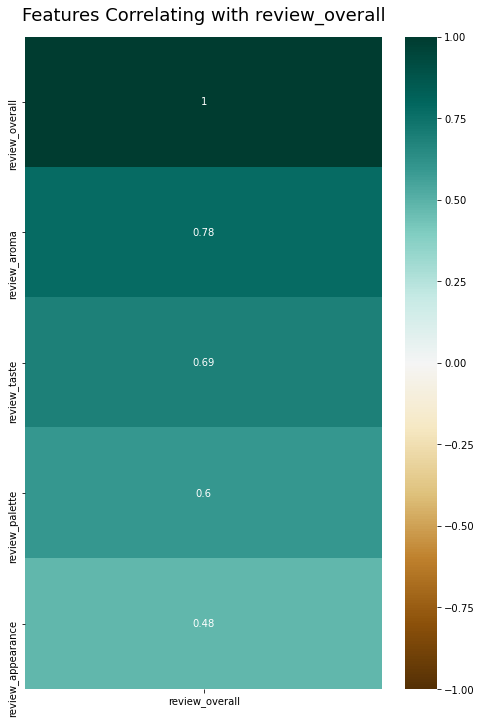

In [25]:
factors = ["review_appearance","review_aroma","review_palette","review_taste", "review_overall"]
corr_df = beer_df[factors].corr()
corr_df[['review_overall']].sort_values(by='review_overall', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df[['review_overall']].sort_values(by='review_overall', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with review_overall', fontdict={'fontsize':18}, pad=16)

## 4.If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

Used review_overall column with at least 100 reviews for each beer

**Answer**

* **Citra DIPA**
* **Cantillon Bl�b�r Lambik**
* **Heady Topper**

In [32]:
# Calculate mean review of all beer_name
beer_df.groupby('beer_name')['review_overall'].mean().sort_values(ascending=False).head()

beer_name
Rural People's Common Lager    5.0
Hop It                         5.0
Bubba Imperial Pilsner         5.0
Triple OOO                     5.0
Triple 7 India Pale Ale        5.0
Name: review_overall, dtype: float64

In [33]:
# Calculate count review of all beer_name
beer_df.groupby('beer_name')['review_overall'].count().sort_values(ascending=False).head()

beer_name
Sierra Nevada Celebration Ale                 2998
Sierra Nevada Pale Ale                        2586
Founders Breakfast Stout                      2501
Sierra Nevada Bigfoot Barleywine Style Ale    2491
La Fin Du Monde                               2480
Name: review_overall, dtype: int64

In [34]:
# creating dataframe with 'review' count values
ratings = pd.DataFrame(beer_df.groupby('beer_name')['review_overall'].mean()) 
ratings['num of ratings'] = pd.DataFrame(beer_df.groupby('beer_name')['review_overall'].count())
ratings = ratings[ratings['review_overall'].notna()]

# Looking at beer with at least 100 ratings
atleast_100 = ratings['num of ratings'] >= 100
top3 = ratings[atleast_100].sort_values([('review_overall')], ascending=False)[:3]

In [35]:
# Top 3 beer with at least 100 ratings
top3_beer_lst = top3.reset_index()['beer_name'].values.tolist()
top3_beer_lst

['Citra DIPA', 'Cantillon Bl�b�r Lambik', 'Heady Topper']

## 5.Which Beer style seems to be the favorite based on reviews written by users? 

Used BERT sentiment model to get the sentiment of review_text

Filtering data based on best review_overall

Grouping data by beer_style and selecting 50 review text (due to infra constraint)

Created new column review_nlp with BERT prediction

**Answer - Faro**

In [37]:
# Creating pipeline for BERT model 
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-uncased-sentiment")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer)

In [40]:
# Filtering data based on best review_overall
top_beer_df = beer_df[beer_df.review_overall == 5].reset_index(drop=True)
top_beer_df['review_text'] = top_beer_df['review_text'].str[:512]
top_beer_df['review_text'] = top_beer_df['review_text'].str.lower()

In [57]:
# Grouping data by beer_style and selecting 50 review text
# Processing on less data due to infra constraint
top_style_df = top_beer_df.groupby('beer_style').head(50).reset_index(drop=True)
top_style_df = pd.read_csv('data/style_groups.csv')
top_style_df['review_nlp'] = [nlp(x) for x in top_style_df.review_text]
top_style_df['review_nlp'] = [int(x[0]['label'].split(' ')[0]) for x in top_style_df.review_nlp]
top_style_df.groupby('beer_style')['review_nlp'].mean().sort_values(ascending=False).head(1)


beer_style
Faro    4.75
Name: review_nlp, dtype: float64

## 6. How does written review compare to overall review score for the beer styles?

Group data by beer_style

Filtered 5 rows for each beer_style

Apply BERT sentiment for each review_text

Compared review_overall column with review_nlp generated using BERT model

In [ ]:
style_df = beer_df.groupby('beer_style').head(5).reset_index(drop=True)
style_df['review_text'] = style_df['review_text'].str[:512]
style_df['review_text'] = style_df['review_text'].str.lower()
style_df['review_nlp'] = [nlp(x) for x in style_df.review_text]
style_df['review_nlp'] = [int(x[0]['label'].split(' ')[0]) for x in style_df.review_nlp]

<ipython-input-64-ffa3b69194a3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  style_df = style_df.groupby('beer_style')['review_nlp', 'review_overall'].mean()


<AxesSubplot:xlabel='beer_style'>

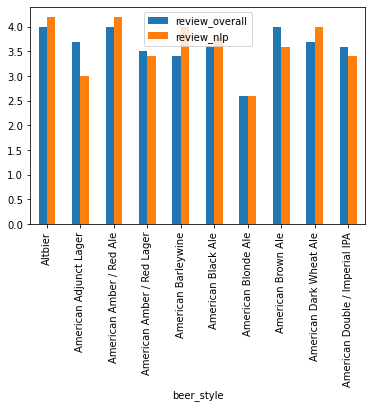

In [64]:
style_df = style_df.groupby('beer_style')['review_nlp', 'review_overall'].mean()
style_df.reset_index(inplace=True)
style_df_plot = style_df.head(10) 
style_df_plot.plot(x="beer_style", y=["review_overall", "review_nlp"], kind="bar")

## 7.How do find similar beer drinkers by using written reviews only?

Performed basic nlp pre-processing technique to clean the reviews (stop word removal, removing special characters, lemmatization)

Perfomed k-means clustering to find similar reviews data

In [60]:
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer() #initialising the wordnet lemmatizer 
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

final_review_text = []
for sent in beer_df['review_text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=wordnet_lemmatizer.lemmatize(cleaned_words.lower())
                    filtered_sentence.append(s)              
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final string of cleaned words    
    final_review_text.append(str1)

In [66]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(final_review_text)
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [67]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 wheat
 light
 yeast
 banana
 beer
 white
 spice
 lemon
 clove
 orange
Cluster 1:
 beer
 taste
 like
 smell
 good
 head
 hop
 light
 flavor
 nice
Cluster 2:
 chocolate
 coffee
 roasted
 dark
 stout
 black
 malt
 beer
 brown
 flavor
Cluster 3:
 hop
 malt
 nice
 citrus
 good
 beer
 head
 pine
 ipa
 flavor
Cluster 4:
 dark
 brown
 sweet
 caramel
 fruit
 malt
 alcohol
 beer
 flavor
 cherry


In [68]:
print("Prediction")
Y = vectorizer.transform(["Brown in color, somewhere between a porter and a brown ale. Lacking in aroma, but no off stuff. Same with the taste, lacking flavor, complexity, just went with smoothness. No off flavors though, so I can't say this is bad, just unadventurous, especially for Caldera, whom I think is generally underrated. You really have to search to pull anything out of this in terms of the usual chocolate/coffee flavors, really, the only thing I can tell is that the oats did their job, because this is smooth and unoffensive. Other than that, extremely pedestrian."])
prediction = model.predict(Y)
print(prediction)

Prediction
[1]
